## Generate Dataset

Generate multiple Shepp-Logan phantom samples and save them as PNG files:

In [ ]:
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from phantominator import shepp_logan

# Configuration
phantom_type = 'modified'  # 'original' or 'modified'
nsamples = 80000  # Number of samples to generate
image_size = 128  # Size of the phantom

# LoRA dataset output (images + metadata.jsonl)
output_folder = 'generated_data'
images_dir = output_folder  
metadata_jsonl_path = os.path.join(output_folder, 'metadata.jsonl')

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Base seed
from datetime import datetime
seed = int(datetime.now().timestamp())

# Get base ellipse parameters to understand structure
# We need the base E matrix to modify specific features
modified = (phantom_type == 'modified')
base_phantom = shepp_logan(image_size, modified=modified, ret_E=True)
_, E_base = base_phantom

# Feature definitions helpers
# 0: Outer Skull (Bone)
# 1: Inner Skull (Brain boundary)
# 2,3: Ventricles (Left/Right) - "Larger black things"
# 4: Central Structure (CSF?) - "Big thing in the middle"
# 5,6: Additional central small structures
# 7,8,9: Base lesions (bottom)

def _get_existing_indices(folder):
    indices = set()
    if os.path.isdir(folder):
        for name in os.listdir(folder):
            if name.endswith('.png'):
                try:
                    indices.add(int(name.split('.')[0]))
                except ValueError: pass
    return indices

existing_indices = _get_existing_indices(images_dir)
start_index = 1
while start_index in existing_indices:
    start_index += 1

pad_width = 5
mode = 'a' if os.path.exists(metadata_jsonl_path) else 'w'

print(f"Generating {nsamples} controlled samples in '{output_folder}'...")

created = 0

with open(metadata_jsonl_path, mode) as jsonl_file:
    for j in range(nsamples):
        file_index = start_index + j
        file_name = f"{file_index:0{pad_width}d}.png"
        output_path = os.path.join(images_dir, file_name)
        
        # Skip if exists
        if os.path.exists(output_path):
            continue

        # Per-sample RNG
        rng = np.random.default_rng(seed + file_index)
        
        # --- 1. Control Parameters (Normalized 0-1) ---
        # We sample a uniform parameter p_ for each feature between 0 and 1.
        # Then we map it to the physical scale.
        
        p_ventricle = rng.uniform(0, 1)
        p_bone = rng.uniform(0, 1)
        p_brain = rng.uniform(0, 1)
        p_lesion_count = rng.uniform(0, 1)
        p_lesion_size = rng.uniform(0, 1)
        p_csf = rng.uniform(0, 1)
        
        # --- 2. Map Normalized Params to Physical Scales ---
        
        # Feature 1: Ventricles Size (0.6 to 1.8)
        ventricle_scale = 0.6 + p_ventricle * (1.8 - 0.6)
        
        # Feature 2: Bone Thickness (0.5 to 3.0)
        bone_thickness_scale = 0.5 + p_bone * (3.0 - 0.5)
        
        # Feature 3: Brain Size (0.85 to 1.15)
        brain_size_scale = 0.85 + p_brain * (1.15 - 0.85)
        
        # Feature 4: Number of Lesions (0 to 5)
        num_lesions = int(round(p_lesion_count * 5))
        
        # Feature 5: Size of Lesions (0.5 to 2.5)
        lesion_size_scale = 0.5 + p_lesion_size * (2.5 - 0.5)
        
        # Feature 6: CSF Size (0.6 to 1.8)
        csf_size_scale = 0.6 + p_csf * (1.8 - 0.6)
        
        # --- 3. Construct Modified E Matrix ---
        E = E_base.copy()
        
        # Apply Brain Scale (Feature 3)
        E[1, 1] *= brain_size_scale # Major
        E[1, 2] *= brain_size_scale # Minor
        
        # Apply Bone Thickness (Feature 2)
        base_gap_major = E_base[0, 1] - E_base[1, 1]
        base_gap_minor = E_base[0, 2] - E_base[1, 2]
        
        E[0, 1] = E[1, 1] + (base_gap_major * bone_thickness_scale)
        E[0, 2] = E[1, 2] + (base_gap_minor * bone_thickness_scale)
        
        # Apply Ventricle Scale (Feature 1) -> Ellipses 2 and 3
        for idx in [2, 3]:
            E[idx, 1] = E_base[idx, 1] * brain_size_scale * ventricle_scale
            E[idx, 2] = E_base[idx, 2] * brain_size_scale * ventricle_scale
            E[idx, 3] = E_base[idx, 3] * brain_size_scale
            E[idx, 4] = E_base[idx, 4] * brain_size_scale
            
        # Apply CSF Scale (Feature 6) -> Ellipse 4
        for idx in [4]:
            E[idx, 1] = E_base[idx, 1] * brain_size_scale * csf_size_scale
            E[idx, 2] = E_base[idx, 2] * brain_size_scale * csf_size_scale
            E[idx, 3] *= brain_size_scale
            E[idx, 4] *= brain_size_scale

        # Feature 4 & 5: Lesions
        # Rebuild E list, keeping E0-E6
        E_list = [row for row in E[0:7]]
        
        # Base lesion dimensions
        base_lesion_dims = (0.046, 0.046) 
        
        # Generate new lesions
        for l_idx in range(num_lesions):
            # Scale size
            l_a = base_lesion_dims[0] * brain_size_scale * lesion_size_scale
            l_b = base_lesion_dims[1] * brain_size_scale * lesion_size_scale
            
            # Random position inside brain (E1)
            found = False
            for attempt in range(50):
                lx = rng.uniform(-0.5, 0.5) * brain_size_scale
                ly = rng.uniform(-0.7, 0.6) * brain_size_scale 
                
                # Check if inside ellipsoid E1
                term = (lx / E[1, 1])**2 + (ly / E[1, 2])**2
                if term < 0.8:
                    found = True
                    break
            
            if not found:
                lx, ly = 0, -0.6 * brain_size_scale 
            
            E_list.append([0.1, l_a, l_b, lx, ly, 0.0])
            
        E_final = np.array(E_list)
        
        # --- 4. Random Affine Transformations (Global & Local) ---
        
        # A. Global Head Movement 
        rot_angle_global = np.deg2rad(rng.uniform(-10, 10))
        shift_x_global = rng.uniform(-0.05, 0.05)
        shift_y_global = rng.uniform(-0.05, 0.05)
        
        # Apply Global Rotation to all centers
        c, s = np.cos(rot_angle_global), np.sin(rot_angle_global)
        x_orig = E_final[:, 3].copy()
        y_orig = E_final[:, 4].copy()
        
        E_final[:, 3] = x_orig * c - y_orig * s + shift_x_global
        E_final[:, 4] = x_orig * s + y_orig * c + shift_y_global
        
        E_final[:, 5] += rot_angle_global

        # B. Local Element Jitter (Organic asymmetry)
        n_elems = len(E_final)
        if n_elems > 1:
            E_final[1:, 3] += rng.normal(0, 0.008, n_elems-1)
            E_final[1:, 4] += rng.normal(0, 0.008, n_elems-1)
            E_final[1:, 5] += rng.normal(0, np.deg2rad(2.0), n_elems-1)

        # Generate Image
        ph = shepp_logan(image_size, modified=modified, E=E_final)
        ph = np.clip(ph, 0, 1)
        
        # --- 5. Generate Caption ---
        features = []
        
        # Classification thresholds roughly mapped from p_ values
        # Low < 0.25 (approx), High > 0.75 (approx)
        
        # Ventricles
        if p_ventricle < 0.25: features.append("small ventricles")
        elif p_ventricle > 0.75: features.append("large ventricles")
        else: features.append("normal ventricles")
        
        # Bone
        if p_bone < 0.2: features.append("thin skull bone")
        elif p_bone > 0.7: features.append("thick skull bone")
        else: features.append("normal skull bone")
        
        # Brain Size
        if p_brain < 0.3: features.append("small brain area")
        elif p_brain > 0.7: features.append("large brain area")
        else: features.append("normal brain area")
        
        # Lesions
        if num_lesions == 0: features.append("no lesions")
        elif num_lesions == 1: features.append("1 lesion")
        else: features.append(f"{num_lesions} lesions")
        
        if num_lesions > 0:
            if p_lesion_size < 0.3: features.append("small lesions")
            elif p_lesion_size > 0.7: features.append("large lesions")
            else: features.append("normal sized lesions")
            
        # CSF
        if p_csf < 0.25: features.append("small CSF")
        elif p_csf > 0.75: features.append("large CSF")
        else: features.append("normal CSF")
        
        caption = "Synthetic Shepp-Logan phantom with " + ", ".join(features)
        
        # Save Image
        plt.imsave(output_path, ph, cmap='gray', vmin=0, vmax=1)
        
        # Save Metadata
        jsonl_file.write(json.dumps({'file_name': file_name, 'text': caption}) + "\n")
        
        created += 1
        if created % 100 == 0:
            print(f"Created {created}/{nsamples} images")

print(f"Finished. Created {created} images in {output_folder}")


Generating 10000 controlled samples in 'generated_data'...
Created 100/10000 images
Created 200/10000 images
Created 300/10000 images
Created 400/10000 images
Created 500/10000 images
Created 600/10000 images
Created 700/10000 images
Created 800/10000 images
Created 900/10000 images
Created 1000/10000 images
Created 1100/10000 images
Created 1200/10000 images
Created 1300/10000 images
Created 1400/10000 images
Created 1500/10000 images
Created 1600/10000 images
Created 1700/10000 images
Created 1800/10000 images
Created 1900/10000 images
Created 2000/10000 images
Created 2100/10000 images
Created 2200/10000 images
Created 2300/10000 images
Created 2400/10000 images
Created 2500/10000 images
Created 2600/10000 images
Created 2700/10000 images
Created 2800/10000 images
Created 2900/10000 images
Created 3000/10000 images
Created 3100/10000 images
Created 3200/10000 images
Created 3300/10000 images
Created 3400/10000 images
Created 3500/10000 images
Created 3600/10000 images
Created 3700/1

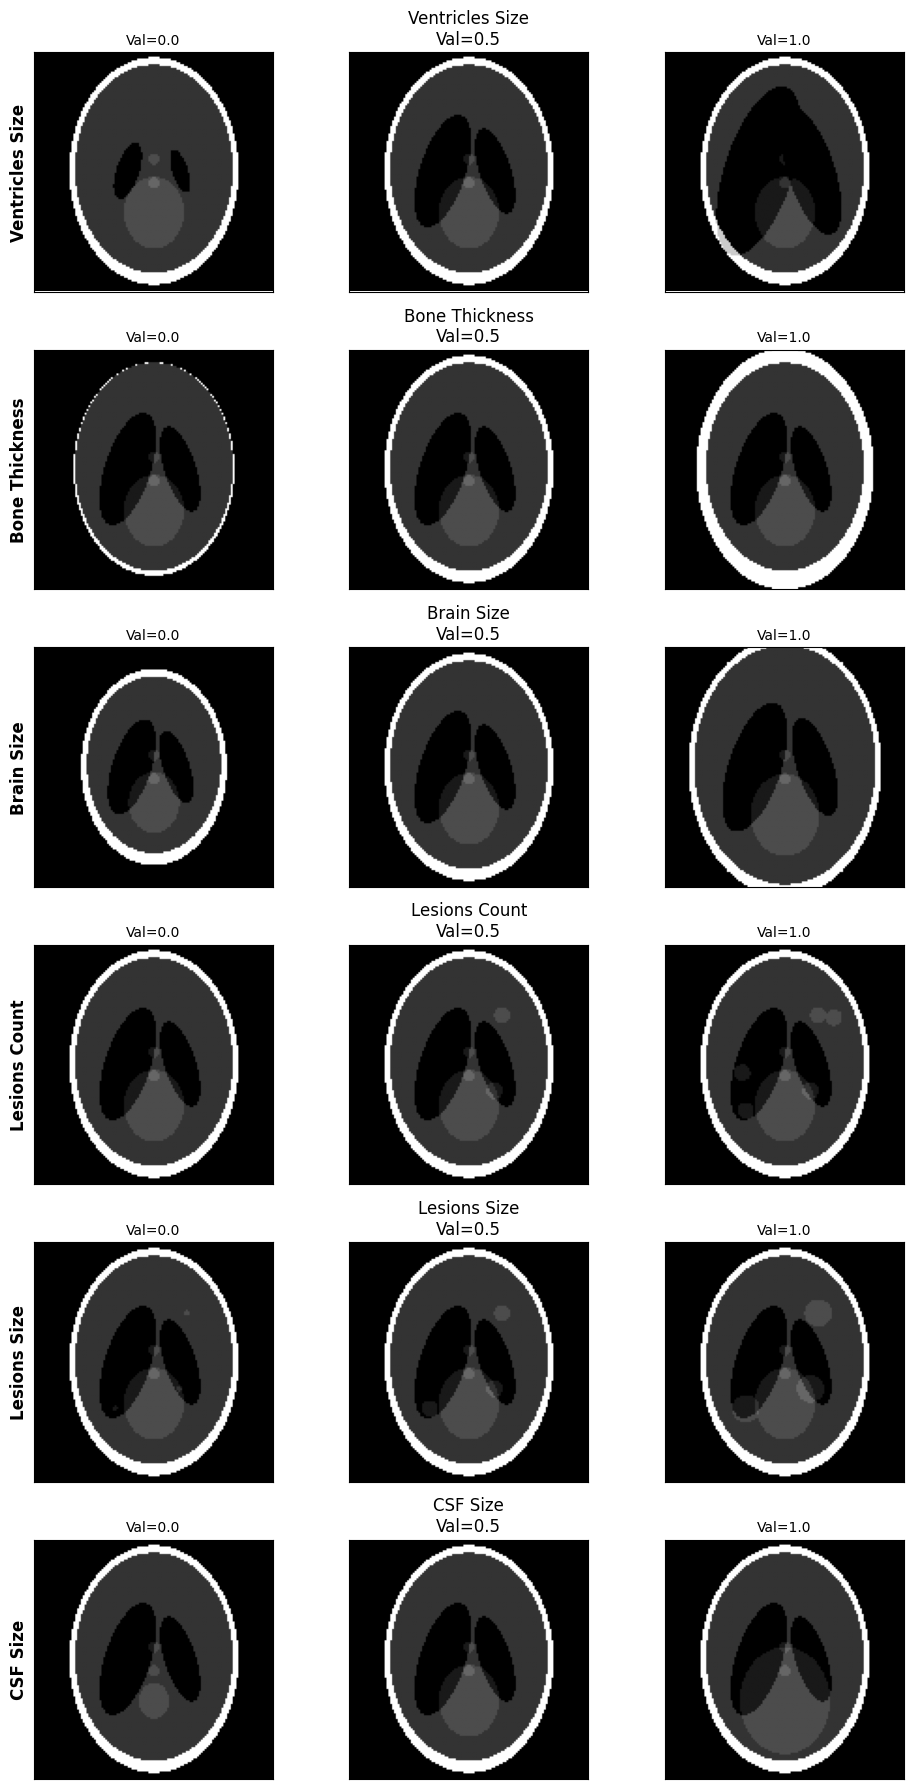

In [2]:
# --- Visualization of Controlled Parameters ---
# Show the effect of each parameter at 0 (Min), 0.5 (Mid), and 1 (Max)

def generate_custom_phantom_normalized(
    p_ventricle=0.5, 
    p_bone=0.5, 
    p_brain=0.5, 
    p_lesion_count=0.5, 
    p_lesion_size=0.5, 
    p_csf=0.5
):
    # Base
    modified = True
    base_phantom = shepp_logan(128, modified=modified, ret_E=True)
    _, E_base = base_phantom
    E = E_base.copy()
    
    # Map Params [0,1] -> Physical Scales
    ventricle_scale = 0.6 + p_ventricle * (1.8 - 0.6)
    bone_thickness_scale = 0.5 + p_bone * (3.0 - 0.5)
    brain_size_scale = 0.85 + p_brain * (1.15 - 0.85)
    num_lesions = int(round(p_lesion_count * 5))
    lesion_size_scale = 0.5 + p_lesion_size * (2.5 - 0.5)
    csf_size_scale = 0.6 + p_csf * (1.8 - 0.6)
    
    # 1. Brain Scale (E1)
    E[1, 1] *= brain_size_scale
    E[1, 2] *= brain_size_scale
    
    # 2. Bone Thickness (E0)
    base_gap_major = E_base[0, 1] - E_base[1, 1]
    base_gap_minor = E_base[0, 2] - E_base[1, 2]
    E[0, 1] = E[1, 1] + (base_gap_major * bone_thickness_scale)
    E[0, 2] = E[1, 2] + (base_gap_minor * bone_thickness_scale)
    
    # 3. Ventricles (E2, E3)
    for idx in [2, 3]:
        E[idx, 1] = E_base[idx, 1] * brain_size_scale * ventricle_scale
        E[idx, 2] = E_base[idx, 2] * brain_size_scale * ventricle_scale
        E[idx, 3] = E_base[idx, 3] * brain_size_scale
        E[idx, 4] = E_base[idx, 4] * brain_size_scale

    # 4. CSF (E4)
    for idx in [4]:
        E[idx, 1] = E_base[idx, 1] * brain_size_scale * csf_size_scale
        E[idx, 2] = E_base[idx, 2] * brain_size_scale * csf_size_scale
        E[idx, 3] *= brain_size_scale
        E[idx, 4] *= brain_size_scale
        
    # 5. Lesions
    # Keep E0-E6
    E_list = [row for row in E[0:7]]
    
    # Add `num_lesions`
    rng = np.random.default_rng(999) # fixed seed for vis (different from generation)
    base_lesion_dims = (0.046, 0.046)
    
    for i in range(num_lesions):
        l_a = base_lesion_dims[0] * brain_size_scale * lesion_size_scale
        l_b = base_lesion_dims[1] * brain_size_scale * lesion_size_scale
        
        # Random positions 
        lx = rng.uniform(-0.5, 0.5) * brain_size_scale
        # force spacing for visualization clarity?
        # just use random
        ly = rng.uniform(-0.6, 0.5) * brain_size_scale
        
        E_list.append([0.1, l_a, l_b, lx, ly, 0])
        
    E_final = np.array(E_list)
    return shepp_logan(128, modified=modified, E=E_final)

# Plotting Grid: 6 Features (rows) x 3 Levels (cols)
features_list = [
    ('Ventricles Size', 'p_ventricle'),
    ('Bone Thickness', 'p_bone'),
    ('Brain Size', 'p_brain'),
    ('Lesions Count', 'p_lesion_count'),
    ('Lesions Size', 'p_lesion_size'),
    ('CSF Size', 'p_csf')
]

levels = [0.0, 0.5, 1.0]
level_names = ["Min (0.0)", "Mid (0.5)", "Max (1.0)"]

fig, axes = plt.subplots(6, 3, figsize=(10, 18))

# Default baseline params (all 0.5)
base_p = {
    'p_ventricle': 0.5, 
    'p_bone': 0.5, 
    'p_brain': 0.5, 
    'p_lesion_count': 0.0, # default 0 lesions for clarity unless testing lesions
    'p_lesion_size': 0.5, 
    'p_csf': 0.5
}

for r, (feat_name, param_key) in enumerate(features_list):
    for c, val in enumerate(levels):
        # Prepare params for this cell
        # Start with base defaults
        curr_p = base_p.copy()
        
        # Override the specific feature being tested
        curr_p[param_key] = val
        
        # Special case: If testing lesion size, ensure we have lesions to see!
        if param_key == 'p_lesion_size' and curr_p['p_lesion_count'] == 0:
            curr_p['p_lesion_count'] = 0.6 # Ensure ~3 lesions
            
        # Generate
        ph = generate_custom_phantom_normalized(**curr_p)
        
        ax = axes[r, c]
        ax.imshow(ph, cmap='gray', vmin=0, vmax=1)
        
        if c == 1:
            ax.set_title(f"{feat_name}\nVal={val}", fontsize=12)
        else:
            ax.set_title(f"Val={val}", fontsize=10)
            
        if c == 0:
            ax.set_ylabel(feat_name, fontsize=12, fontweight='bold')
            
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig('parameter_visualization.png', dpi=150) # Save for README use
plt.show()
